# Import modules

In [1]:
from EngineMethods import FeatureExtraction, get_labels
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_recall_curve
from param import query_path
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time

# Load database features

In [2]:
fe = FeatureExtraction()
database_pca_features = fe.load_database_features('pca_features')

# Get query images, Retrieve, and Evaluate

In [3]:
query_paths = []
for label in os.listdir(query_path):
    query_images = os.listdir(os.path.join(query_path, label))
    for image in query_images:
        query_paths.append(os.path.join(query_path, label, image))
no_query = len(query_paths)

In [4]:
precision_1 = 0
precision_10 = 0
retrieval_time = 0
all_ground_truth = []
all_retrieved_images = [1] * 10 * no_query

for query_img_path in query_paths:
    query_img = cv2.imread(query_img_path)
    start_time = time.time()
    query_pca_features = fe.extract_pca_features(query_img)
    cos_sim = cosine_similarity(query_pca_features.reshape(1, -1), np.vstack(list(database_pca_features.values())))[0]
    top_10_indices = np.argsort(cos_sim)[-10:][::-1]
    top_10_paths = np.array(list(database_pca_features.keys()))[top_10_indices]
    end_time = time.time()
    precision_1 += 1.0 if any(label in get_labels(query_img_path) for label in get_labels(top_10_paths[0])) else 0.0
    precision_10 += sum(1 for path in top_10_paths if any(label in get_labels(query_img_path) for label in get_labels(path)))
    retrieval_time += (end_time - start_time)
    all_ground_truth.extend([1 if any(label in get_labels(query_img_path) for label in get_labels(path)) else 0 for path in top_10_paths])

In [5]:
precision_1 = 100 * precision_1 / no_query
precision_10 = 100 * precision_10 / (no_query * 10)
retrieval_time /= no_query
average_precision, average_recall, _ = precision_recall_curve(all_ground_truth, all_retrieved_images)

In [8]:
print(f'Precision at 1: {precision_1:.2f}%')
print(f'Precision at 10: {precision_10:.2f}%')
print(f'Retrieval Time: {retrieval_time:.2f} seconds')

Precision at 1: 50.06%
Precision at 10: 34.14%
Retrieval Time: 0.10 seconds


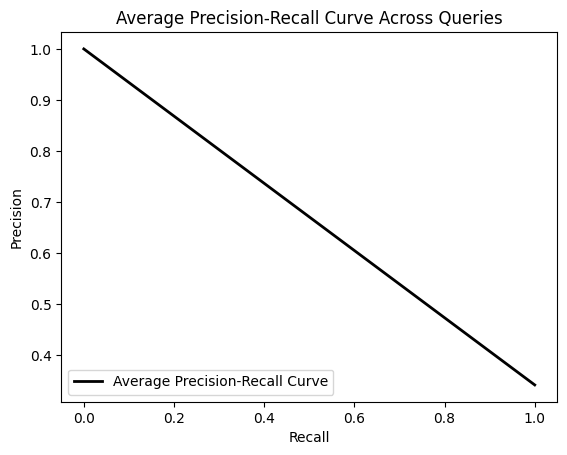

In [7]:
# Plot the average precision-recall curve
plt.plot(average_recall, average_precision, label='Average Precision-Recall Curve', linewidth=2, color='black')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Average Precision-Recall Curve Across Queries')
plt.legend(loc='lower left')
plt.show()

# Visualize Random queries and retrieved images

In [37]:
random_queries = np.random.choice(np.array(query_paths), 10)

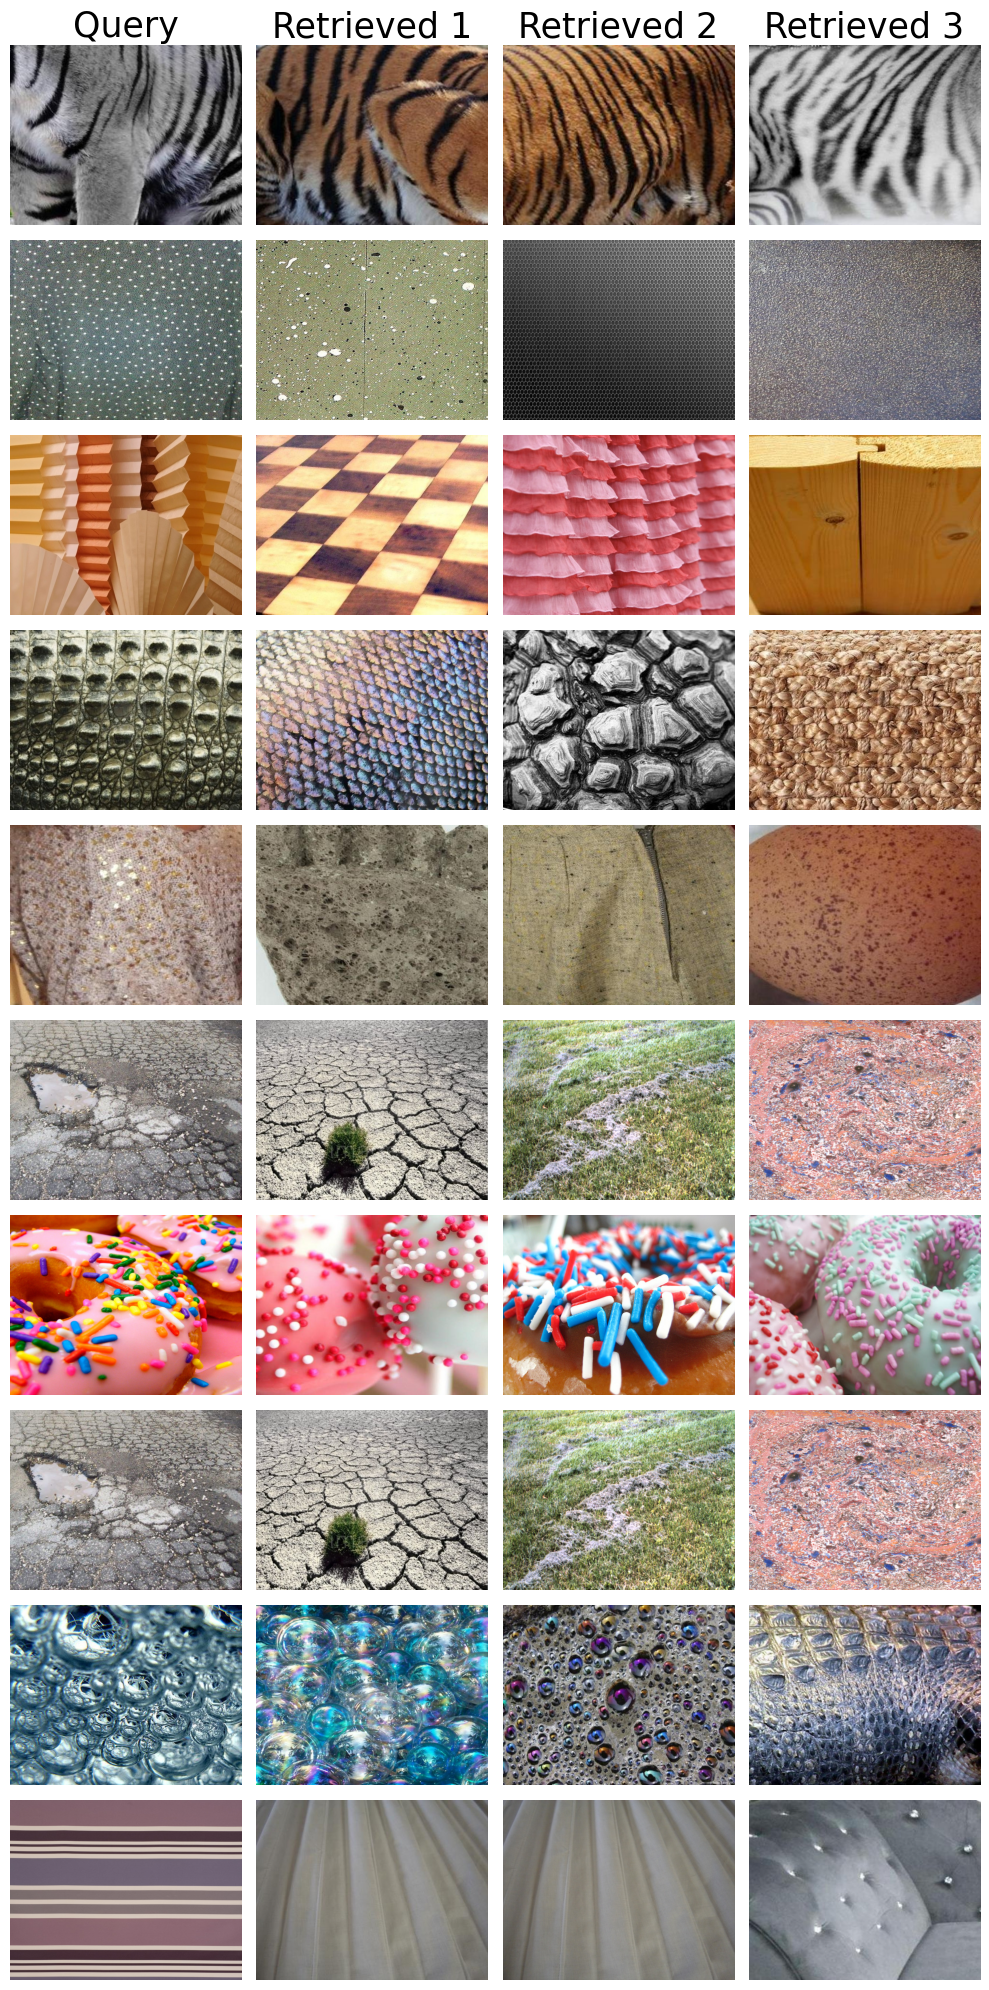

In [38]:
fig, axes = plt.subplots(10, 4, figsize=(10, 20))

column_labels = ['Query'] + [f'Retrieved {i+1}' for i in range(3)]
for j, label in enumerate(column_labels):
    axes[0, j].set_title(label, fontsize=25)

    
for i, query_image_path in enumerate(random_queries):
    query_img = cv2.imread(query_image_path)
    query_pca_features = fe.extract_pca_features(query_img)
    cos_sim = cosine_similarity(query_pca_features.reshape(1, -1), np.vstack(list(database_pca_features.values())))[0]
    top_3_indices = np.argsort(cos_sim)[-3:][::-1]
    top_3_paths = np.array(list(database_pca_features.keys()))[top_3_indices]
    axes[i, 0].imshow(cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB), extent=[0, 1, 0, 1], aspect='auto')
    axes[i, 0].axis('off')
    
    for j, retrieved_path in enumerate(top_3_paths):
        img = cv2.cvtColor(cv2.imread(retrieved_path), cv2.COLOR_BGR2RGB)
        axes[i, j + 1].imshow(img, extent=[0, 1, 0, 1], aspect='auto')
        axes[i, j + 1].axis('off')

plt.tight_layout()
plt.show()

In [39]:
fig.savefig('visualization_plot1.png', bbox_inches='tight');